In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
import os
from abc import abstractmethod

In [58]:
OUTPUT_PATH = 'output/'
INPUT_PATH = 'dataset/'
BASE_FILE_NAME='btcusdt'
TIME_FRAMES=['1h']

SIGNALS = [-1,0,1]
PRICE_TYPES = ['open','close','high','low']

TIMEFRAME="1h"

PRICE_TYPE="open"
PRICE_STUDY="close"
PRICE_TRADING="open"

In [59]:
class PrVO:
    def __init__(self,open:float,high:float,low:float,close:float,volume:int,timeStamp:datetime) -> None:
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.timeStamp = timeStamp
        self.returns = (close - open)/open
        self.candle_color = 'GREEN' if self.close > self.open else 'RED'

    def __repr__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    
    def __str__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    
class Trade:
    
    def __init__(self) -> None:
        self.timeStamp = None
        self.signal = None
        self.price_type = None
    
    def execute(self,PrVo:PrVO ,signal:int,price_type:str) -> object:
        
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"

        self.PrVo = PrVo
        self.signal = signal
        self.price_type = price_type
        return self
    
    def __str__(self) -> str:
        return f"{self.PrVo}\t{self.signal}\t {self.price_type}"
    

In [60]:
class TradingTerminal:

    def __init__(self) -> None:
        self.PrVo=dict()
        self.cash_balance=1000
        self.tradeHistory=[]
        self.transaction_penalty=0.001
        self.transaction_cost=0


        if '1d' in TIME_FRAMES:
            self.create1DTimeFrame()

        for timeframe in TIME_FRAMES:
            self.readData(BASE_FILE_NAME+'_'+timeframe+'.xlsx')

    def create1DTimeFrame(self):
        
        if os.path.isfile(INPUT_PATH+BASE_FILE_NAME+'_1d.xlsx'):
            return
        df=pd.read_excel(INPUT_PATH+BASE_FILE_NAME+'_30m.xlsx')
        df['date']=df['datetime'].dt.date
        df['time']=df['datetime'].dt.time
        df=df.drop(columns=['datetime'])
        df=df.drop(columns=['time'])
        df=df.rename(columns={'date':'datetime'})
        df=df.groupby('datetime').agg({'low':lambda x: x.min(),'high':lambda x: x.max(),'open':lambda x: x.iloc[0],'close':lambda x: x.iloc[-1],'volume':lambda x: x.sum()})
        df.to_excel(INPUT_PATH+BASE_FILE_NAME+'_1d.xlsx')

    def readData(self,filepath:str):
        df=pd.read_excel(INPUT_PATH+filepath)
        
        data=[]
        for index,row in df.iterrows():
            data.append(PrVO(row['open'],row['high'],row['low'],row['close'],row['volume'],row['datetime']))

        data_timeframe=filepath.split('/')[-1].split('.')[0].split('_')[1]
        self.PrVo[data_timeframe]=np.array(data)
        
    def takeTrade(self,PrVo:PrVO,signal:int,price_type:str):
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"

        trade=Trade().execute(PrVo,signal,price_type)
        self.tradeHistory.append(trade)

    def outputTradeHistory(self):
        file=open(OUTPUT_PATH+'trade_history.csv','w')

        file.write(f"Index,datetime,signals,open,high,low,close,volume\n")
        
        for index,trade in enumerate(self.tradeHistory):
            file.write(f"{index},{trade.PrVo.timeStamp},{trade.signal},{trade.PrVo.open},{trade.PrVo.high},{trade.PrVo.low},{trade.PrVo.close},{trade.PrVo.volume}\n")

    def resetEverything(self):
        self.cash_balance=1000
        self.tradeHistory=[]
        self.transaction_cost=0

    def getstatsCompounded(self):

        equity_curve = np.array([])
        coins_held=0

        trades_type={"Winnings":0,"Losings":0,"Total":0}
        trades_amount={"Gain":0,"Loss":0}  
        Holding_time=[]
        prev_time=None

        prev_trade_value=self.cash_balance      

        for trade in self.tradeHistory:

            equity_value=self.cash_balance+abs(coins_held)*getattr(trade.PrVo,trade.price_type)
            equity_curve=np.append(equity_curve,equity_value)

            if coins_held == 0:

                prev_trade_value=self.cash_balance
                self.transaction_cost+=self.transaction_penalty*self.cash_balance                
                if trade.signal==1:
                    coins_held=(self.cash_balance*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                elif trade.signal==-1:
                    coins_held=(-1)*(self.cash_balance*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                    
            
                self.cash_balance=0
                prev_time=trade.PrVo.timeStamp
                
            else:

                value_coins=abs(coins_held)*getattr(trade.PrVo,trade.price_type)
                self.transaction_cost+=self.transaction_penalty*value_coins
                trades_type['Total']+=1

                if trade.signal==1:
                    assert coins_held<0,"Coins Held should be negative"
                elif trade.signal==-1:
                    assert coins_held>0,"Coins Held should be positive"
                    
                self.cash_balance=(1-self.transaction_penalty)*value_coins
                coins_held=0
                trades_type['Winnings' if self.cash_balance>prev_trade_value else 'Losings']+=1
                trades_amount['Gain'  if self.cash_balance>prev_trade_value else 'Loss']+=self.cash_balance-prev_trade_value
                Holding_time.append(trade.PrVo.timeStamp-prev_time)
                prev_time=None

        print(f"Final Cash Balance : {self.cash_balance}")
        print("Transaction Cost : ",self.transaction_cost)
        print(f"Total Trades : {trades_type['Total']}")
        print(f"Winning Trades : {trades_type['Winnings']}")
        print(f"Losing Trades : {trades_type['Losings']}")
        print(f"Average Holding Time : {np.mean(Holding_time)}")
        print(f"Maximum Holding Time : {np.max(Holding_time)}")

        try:
            print(f"Winning Percentage : {100*trades_type['Winnings']/trades_type['Total']}")
        except:
            print(f"Winning Percentage: No trades were made")
        try:
            print(f"Average Profit per Wins: {trades_amount['Gain']/trades_type['Winnings']}")
        except:
            print(f"Average Profit per Wins : No Winning Trades were made")

        try:
            print(f"Average Lost per Loss: {trades_amount['Loss']/trades_type['Losings']}")
        except:
            print(f"Average Lost per Loss : No Losing Trades were made")
        
        try:
            print(f"Profit to Loss Ratio : {trades_amount['Gain']/abs(trades_amount['Loss'])}")
        except:
            print(f"Profit to Loss Ratio : No Losing Trades were made")
        
        print(f"Minimum Portfolio Value : {np.min(equity_curve)}")
        print(f"Maximum Portfolio Value : {np.max(equity_curve)}")

        self.graphEquityCurve(equity_curve)

    def getstatsStatic(self):

        coins_held=0

        trades_type={"Winnings":0,"Losings":0,"Total":0}
        trades_amount={"Gain":0,"Loss":0}  

        TRADE_VALUE=1000      

        for trade in self.tradeHistory:

            if coins_held == 0:

                self.transaction_cost+=self.transaction_penalty*TRADE_VALUE

                if trade.signal==1:
                    coins_held=(TRADE_VALUE*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                elif trade.signal==-1:
                    coins_held=(-1)*(TRADE_VALUE*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                            
            else:

                value_coins=abs(coins_held)*getattr(trade.PrVo,trade.price_type)
                self.transaction_cost+=self.transaction_penalty*value_coins
                value_coins*=1-self.transaction_penalty
                trades_type['Total']+=1

                if trade.signal==1:
                    assert coins_held<0,"Coins Held should be negative"
                elif trade.signal==-1:
                    assert coins_held>0,"Coins Held should be positive"
                    
                coins_held=0
                trades_type['Winnings' if value_coins>TRADE_VALUE else 'Losings']+=1
                trades_amount['Gain'  if value_coins>TRADE_VALUE else 'Loss']+=value_coins-TRADE_VALUE



        print(f"Final Pnl : {trades_amount['Gain']+trades_amount['Loss']}")
        print("Transaction Cost : ",self.transaction_cost)
        print(f"Total Trades : {trades_type['Total']}")
        print(f"Winning Trades : {trades_type['Winnings']}")
        print(f"Losing Trades : {trades_type['Losings']}")

        try:
            print(f"Winning Percentage : {100*trades_type['Winnings']/trades_type['Total']}")
        except:
            print(f"Winning Percentage: No trades were made")
        try:
            print(f"Average Profit per Wins: {trades_amount['Gain']/trades_type['Winnings']}")
        except:
            print(f"Average Profit per Wins : No Winning Trades were made")

        try:
            print(f"Average Lost per Loss: {trades_amount['Loss']/trades_type['Losings']}")
        except:
            print(f"Average Lost per Loss : No Losing Trades were made")
        
        try:
            print(f"Profit to Loss Ratio : {trades_amount['Gain']/abs(trades_amount['Loss'])}")
        except:
            print(f"Profit to Loss Ratio : No Losing Trades were made")

    def graphEquityCurve(self,equity_curve:[float]):

        sns.set()
        plt.figure(figsize=(8, 8))
        plt.plot(equity_curve)
        plt.xlabel('Transactions')
        plt.ylabel('Equity Curve')
        plt.show()
        
    def graphIndex(self,timeframe:str,price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sns.set()
        plt.figure(figsize=(8, 8))
        plt.plot(prices)
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.show()

    # INDICATORS

    def getSimpleMovingAverage(self, lag:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"
        
        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = np.convolve(prices, np.ones(lag) / lag, mode='valid')
        sma = np.concatenate([np.full(lag - 1, np.nan), sma])
        return sma

    def getExponentialMovingAverage(self, span:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        ema = pd.Series(prices).ewm(span=span, adjust=False).mean().values
        return ema
    
    def getBollingerBands(self, lag:int, std_dev_factor:float, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = self.getExponentialMovingAverage(lag, timeframe, price_type)
        
        rolling_std = pd.Series(prices).rolling(window=lag).std().values

        upper_band = sma + std_dev_factor * rolling_std
        lower_band = sma - std_dev_factor * rolling_std

        return (upper_band, sma, lower_band)

    def calculateRSI(self, period:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])

        price_changes = np.diff(prices)
        gains = np.where(price_changes > 0, price_changes, 0)
        losses = np.where(price_changes < 0, -price_changes, 0)
        avg_gain = np.mean(gains[:period])
        avg_loss = np.mean(losses[:period])
        rsi_values = np.zeros_like(prices)
        for i in range(period, len(prices)):
            gain = gains[i - 1] if price_changes[i - 1] > 0 else 0
            loss = losses[i - 1] if price_changes[i - 1] < 0 else 0

            avg_gain = (avg_gain * (period - 1) + gain) / period
            avg_loss = (avg_loss * (period - 1) + loss) / period

            rs = avg_gain / avg_loss if avg_loss != 0 else np.inf
            rsi_values[i] = 100 - (100 / (1 + rs))

        return rsi_values
        
    def calculateMACD(self, slow_period:int, fast_period:int, signal_period:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        slow_ema = self.getExponentialMovingAverage(slow_period, timeframe, price_type)
        fast_ema = self.getExponentialMovingAverage(fast_period, timeframe, price_type)
        macd = fast_ema - slow_ema
        
        macd_temp=macd.copy()
        macd_temp[np.isnan(macd_temp)]=0

        signal= pd.Series(macd_temp).ewm(span=signal_period, adjust=False).mean().values
        return macd, signal

    def calculateATR(self, period:int, timeframe:str):
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        curr_high = np.array([getattr(entry, "high") for entry in self.PrVo[timeframe]])
        curr_low = np.array([getattr(entry, "low") for entry in self.PrVo[timeframe]])

        prev_high = np.roll(curr_high, 1)
        prev_low = np.roll(curr_low, 1)
        prev_high[0] = np.nan
        prev_low[0] = np.nan

        tr = np.maximum(curr_high - curr_low, abs(curr_high - prev_low), abs(curr_low - prev_low))

        atr = np.zeros_like(tr)
        atr[period - 1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period

        return atr

    def calculateSuperTrend(self, period, multiplier, timeframe, price_type):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        atr = self.calculateATR(period, timeframe, price_type)

        upper_band = prices + multiplier * atr
        lower_band = prices - multiplier * atr

        uptrend = True
        supertrend = np.zeros_like(prices)

        for i in range(period, len(prices)):
            if prices[i] > upper_band[i - 1] and uptrend:
                supertrend[i] = lower_band[i]
                uptrend = False
            elif prices[i] < lower_band[i - 1] and not uptrend:
                supertrend[i] = upper_band[i]
                uptrend = True
            else:
                supertrend[i] = supertrend[i - 1] if uptrend else supertrend[i - 1]

        return supertrend

    # ARIMA Models

    def calculateARIMA(self, train_data):

        model = pm.auto_arima(train_data,
                        m=1,
                        d=None,
                        seasonal=False,
                        D=0,
                        trace=False,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
        
        p,d,q = model.order[0], model.order[1], model.order[2]
        model_fit = sm.tsa.arima.ARIMA(train_data, order = (p,d,q))
        
        return model_fit

In [61]:
class Strategy:
    def __init__(self,TradingTerminal:TradingTerminal) -> None:
        self.terminal=TradingTerminal

    @abstractmethod
    def run(self, *args):
        pass

In [62]:
class Benchmark(Strategy):

    def __init__(self,TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self,timeframe:str):
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()

        PrVo=self.terminal.PrVo[timeframe]
        self.terminal.takeTrade(PrVo[0], 1, "open")
        self.terminal.takeTrade(PrVo[-1], -1, "close")   

In [63]:
class Strategy1(Strategy):

    def __init__(self,TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self,lag1:int,lag2:int,timeframe:str):
        assert lag1>lag2, f"Invalid Lag {lag1} {lag2}"
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()

        PrVo=self.terminal.PrVo[timeframe]
        ema1=self.terminal.getSimpleMovingAverage(lag1,timeframe,PRICE_STUDY)
        ema2=self.terminal.getSimpleMovingAverage(lag2,timeframe,PRICE_STUDY)
        rsi=self.terminal.calculateRSI(lag2,timeframe,PRICE_STUDY)
        moving_average_crossover_factor=1.0125
        has_purchased = False
                
        for idx, (e1,e2,r) in enumerate(zip(ema1, ema2,rsi)):

            if not has_purchased:

                if ( (e2 >= moving_average_crossover_factor*e1) or r<=20 ):
                    self.terminal.takeTrade(PrVo[idx+1], 1, PRICE_TRADING)
                    has_purchased = True 

            elif has_purchased:

                if( (e2 <= moving_average_crossover_factor*e1) or r>=80 ):
                    self.terminal.takeTrade(PrVo[idx+1], -1, PRICE_TRADING)
                    has_purchased = False

        if has_purchased:
            self.terminal.takeTrade(PrVo[-1], -1, PRICE_TRADING)    

In [64]:
class Strategy2(Strategy):

    def __init__(self,TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self,lag1:int,lag2:int,timeframe:str,std_dev_factor:float):
        assert lag1>lag2, f"Invalid Lag {lag1} {lag2}"
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()

        PrVo=self.terminal.PrVo[timeframe]
        ema1=self.terminal.getSimpleMovingAverage(lag1,timeframe,PRICE_STUDY)
        ema2=self.terminal.getSimpleMovingAverage(lag2,timeframe,PRICE_STUDY)
        rsi=self.terminal.calculateRSI(lag2,timeframe,PRICE_STUDY)
        
        moving_average_crossover_factor = 1.015
        bollinger_band_factor = 1.015
        
        upper_band, _, lower_band = self.terminal.getBollingerBands(
            lag1, std_dev_factor, timeframe, PRICE_STUDY
        )
        coin_type=0
                
        for idx, (e1, e2,r,upper,lower) in enumerate(zip(ema1, ema2,rsi,upper_band,lower_band)):

            if coin_type==0:
                if ( ((e2 >= moving_average_crossover_factor*e1) and r<=25) or getattr(PrVo[idx],PRICE_STUDY) >= bollinger_band_factor*upper):
                    self.terminal.takeTrade(PrVo[idx+1], 1, PRICE_TRADING)
                    coin_type = 1
                elif ( ((e2 <= (2-moving_average_crossover_factor)*e1 and r>=75) or getattr(PrVo[idx],PRICE_STUDY) <= bollinger_band_factor*lower) ):
                    self.terminal.takeTrade(PrVo[idx+1], -1, PRICE_TRADING)
                    coin_type = -1
                
            else:
                if( ((e2 <= moving_average_crossover_factor*e1) and r>=75) or getattr(PrVo[idx],PRICE_STUDY) <= bollinger_band_factor*lower) and coin_type==1:
                    self.terminal.takeTrade(PrVo[idx+1], -1, PRICE_TRADING)
                    coin_type = 0
                elif( ((e2 >= (2-moving_average_crossover_factor)*e1) and r<=25) or getattr(PrVo[idx],PRICE_STUDY) >= bollinger_band_factor*upper) and coin_type==-1:
                    self.terminal.takeTrade(PrVo[idx+1], 1, PRICE_TRADING)
                    coin_type = 0
                

        if coin_type>0:
            self.terminal.takeTrade(PrVo[-1], -1, PRICE_TRADING) 
        elif coin_type<0:
            self.terminal.takeTrade(PrVo[-1], 1, PRICE_TRADING)

In [106]:
class Strategy3(Strategy):
    def __init__(self, TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self, lag1: int, lag2: int, timeframe: str, std_dev_factor: float):
        assert lag1 > lag2, f"Invalid Lag {lag1} {lag2}"
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()

        PrVo = self.terminal.PrVo[timeframe]
        ema1 = self.terminal.getSimpleMovingAverage(lag1, timeframe, PRICE_STUDY)
        ema2 = self.terminal.getSimpleMovingAverage(lag2, timeframe, PRICE_STUDY)
        
        rsi = self.terminal.calculateRSI(lag2, timeframe, PRICE_STUDY)

        moving_average_crossover_factor = 1.01
        bollinger_band_factor = 1.0125
        upper_band, _, lower_band = self.terminal.getBollingerBands(
            lag1, std_dev_factor, timeframe, PRICE_STUDY
        )

        has_purchased = False

        for idx, (val1, val2, rsi_val, upper, lower) in enumerate(
            zip(ema1, ema2, rsi, upper_band, lower_band)
        ):

            if not has_purchased:

                if (
                    ((val2 >= moving_average_crossover_factor * val1)
                    and rsi_val <= 20)
                    or getattr(PrVo[idx],PRICE_STUDY) >= bollinger_band_factor*upper
                ):
                    self.terminal.takeTrade(PrVo[idx+1], 1,PRICE_TRADING)
                    has_purchased = True

            elif has_purchased:

                if (
                    ((val2 <= moving_average_crossover_factor * val1)
                    and rsi_val >= 80)
                    or getattr(PrVo[idx],PRICE_STUDY) <= bollinger_band_factor*lower
                ):
                    self.terminal.takeTrade(PrVo[idx+1], -1,PRICE_TRADING)
                    has_purchased = False

        if has_purchased:
            self.terminal.takeTrade(PrVo[-1], -1, PRICE_TRADING)

In [66]:
class Strategy4(Strategy):

    def __init__(self,TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self,lookback_period:int,price_type:str,timeframe:str):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()

        PrVo=self.terminal.PrVo[timeframe]
        prices = np.array([getattr(entry, price_type) for entry in PrVo])
        log_prices = np.log(prices)
        has_purchased = False
        bought_price = 0
        
        for current_day in range (lookback_period-1,len(prices)-1):
            train_data = log_prices[current_day-lookback_period+1:current_day+1]
            model = self.terminal.calculateARIMA(train_data)
            model_fit = model.fit()
            forecast = model_fit.forecast()
            curr_val = prices[current_day]
            predicted_tom_val = np.exp(forecast[0])

            if has_purchased==False:
                if predicted_tom_val > curr_val:
                    has_purchased = True
                    bought_price = curr_val
                    self.terminal.takeTrade(PrVo[current_day],1,price_type)
            else:
                if curr_val > bought_price:
                    if curr_val > predicted_tom_val:
                        has_purchased = False
                        self.terminal.takeTrade(PrVo[current_day],-1,price_type)

        if has_purchased:
            self.terminal.takeTrade(PrVo[-1],-1,price_type)

In [67]:
tt=TradingTerminal()

Final Cash Balance : 3105.1895225527046
Transaction Cost :  4.108297820373078
Total Trades : 1
Winning Trades : 1
Losing Trades : 0
Average Holding Time : 1472 days 00:00:00
Maximum Holding Time : 1472 days 00:00:00
Winning Percentage : 100.0
Average Profit per Wins: 2105.1895225527046
Average Lost per Loss : No Losing Trades were made
Profit to Loss Ratio : No Losing Trades were made
Minimum Portfolio Value : 1000.0
Maximum Portfolio Value : 3108.2978203730777


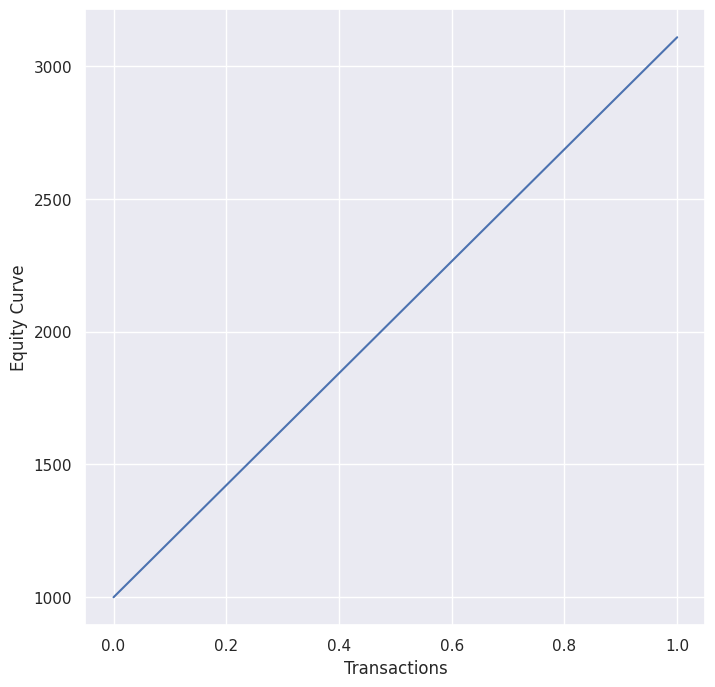

In [68]:
s0=Benchmark(tt)
s0.run(TIMEFRAME)
tt.getstatsCompounded()

Final Cash Balance : 664.4995798791481
Transaction Cost :  760.5945390403625
Total Trades : 752
Winning Trades : 300
Losing Trades : 452
Average Holding Time : 1 days 20:16:54.893617021
Maximum Holding Time : 13 days 19:00:00
Winning Percentage : 39.8936170212766
Average Profit per Wins: 21.53870513442041
Average Lost per Loss: -15.037858319572953
Profit to Loss Ratio : 0.9506407394680035
Minimum Portfolio Value : 180.63011335431372
Maximum Portfolio Value : 1305.8729563552647


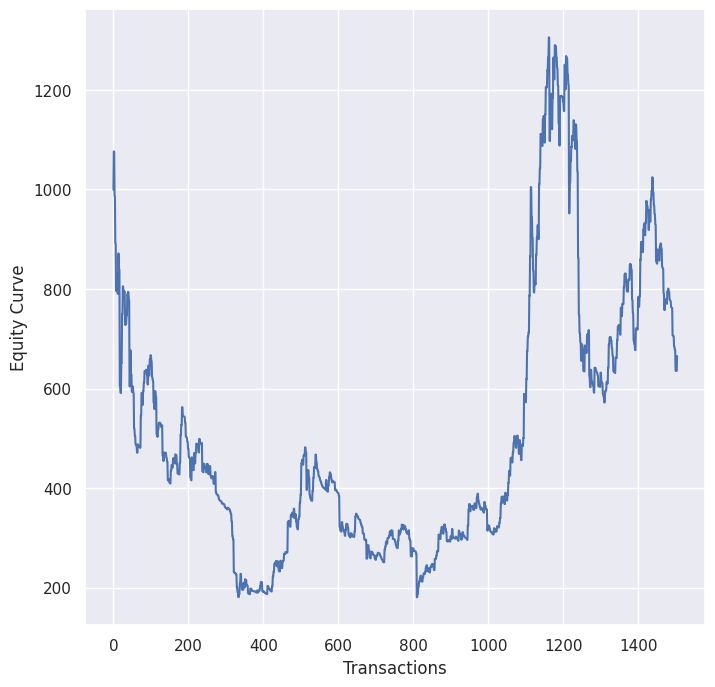

In [69]:
s2=Strategy2(tt)
s2.run(50,10,TIMEFRAME,1)
# tt.outputTradeHistory()
tt.getstatsCompounded()

Final Cash Balance : 744.5253657062266
Transaction Cost :  1562.777234062759
Total Trades : 1028
Winning Trades : 461
Losing Trades : 567
Average Holding Time : 0 days 08:59:45.992217898
Maximum Holding Time : 3 days 19:00:00
Winning Percentage : 44.8443579766537
Average Profit per Wins: 13.261030613870716
Average Lost per Loss: -11.232468690102605
Profit to Loss Ratio : 0.9598865966435004
Minimum Portfolio Value : 401.69642016843267
Maximum Portfolio Value : 1508.6142117179008


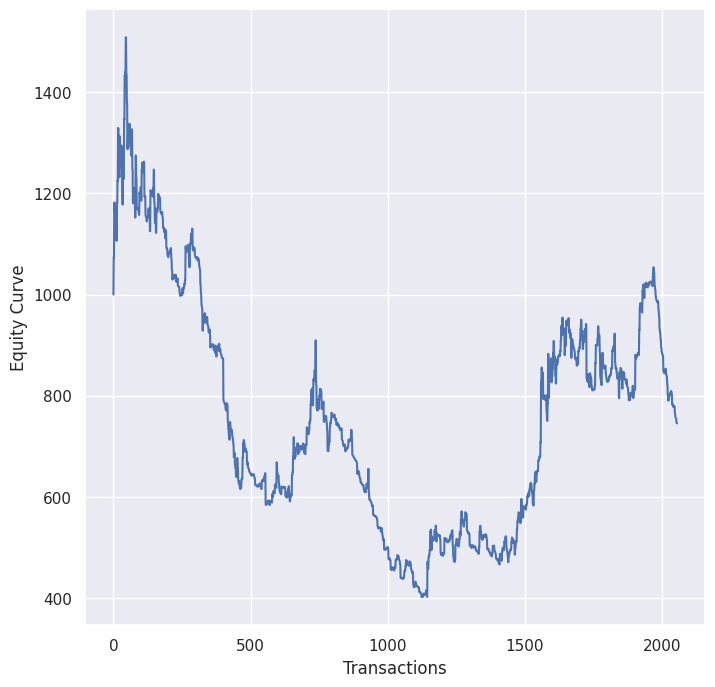

In [70]:
s1=Strategy1(tt)
s1.run(50,10,TIMEFRAME)
# tt.outputTradeHistory()
tt.getstatsCompounded()

Final Cash Balance : 18261.20941360074
Transaction Cost :  1010.1600785585217
Total Trades : 81
Winning Trades : 33
Losing Trades : 48
Average Holding Time : 7 days 03:38:31.111111111
Maximum Holding Time : 28 days 23:00:00
Winning Percentage : 40.74074074074074
Average Profit per Wins: 908.8935225865514
Average Lost per Loss: -265.2557673282387
Profit to Loss Ratio : 2.3557048469563364
Minimum Portfolio Value : 941.0952156614292
Maximum Portfolio Value : 19431.572989745102


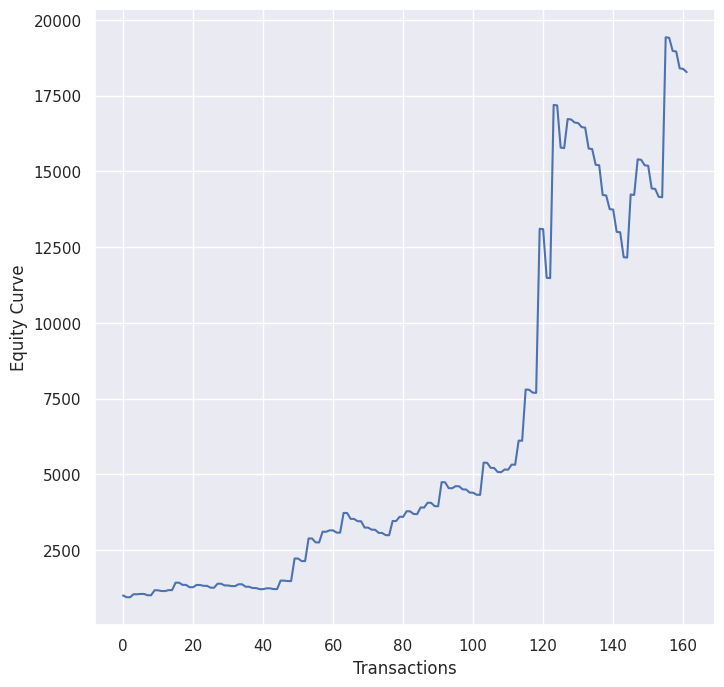


Final Pnl : 3629.2584639574516
Transaction Cost :  1175.8740509949153
Total Trades : 81
Winning Trades : 33
Losing Trades : 48
Winning Percentage : 40.74074074074074
Average Profit per Wins: 161.9125242317217
Average Lost per Loss: -35.70530907686175
Profit to Loss Ratio : 3.1175996871973433


In [107]:
s3 = Strategy3(tt)
s3.run(150, 50,TIMEFRAME, 1)
tt.outputTradeHistory()
tt.getstatsCompounded()
print()
tt.getstatsStatic()

In [72]:
# s4 = Strategy4(tt)
# s4.run(100,PRICE_TYPE,TIMEFRAME)